In [73]:
import glob
import os
import csv
import numpy as np
from scipy.signal import medfilt

genders = ['male', 'female']
labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def preprocess_data(dataPath, train):
    if train:
        path = os.path.join(dataPath, 'train')
        output_dir = os.path.join(dataPath, 'train.csv')
    else:
        path = os.path.join(dataPath, 'val')
        output_dir = os.path.join(dataPath, 'val.csv')
    folders = glob.glob(os.path.join(path, '*'))
    folders.sort()

    with open(output_dir, 'a+') as csv_output_file:
        fieldnames = ['User', 'Max', 'Min', 'Mean', 'Var', 'Mean Abs Diff', 'Mean Abs Second Diff', 'Emotion', 'Gender', 'Age'] # The features extracted
        writer = csv.DictWriter(csv_output_file, fieldnames=fieldnames)
        writer.writeheader()

        for dir in folders:
            with open(os.path.join(dir, 'EDA.csv')) as csv_file:
                csv_reader = csv.reader(csv_file)
                line_count = 0
                data = [] # all data for one person
                time_stamp = [] # time stamp for each item

                for row in csv_reader:
                    if line_count == 0:
                        start_time = float(row[0])
                    elif line_count == 1:
                        freq = float(row[0])
                    elif line_count>2 :
                        data.append(float(row[0]))
                        time_stamp.append(start_time + float((line_count-2)/freq))
                    line_count += 1

                person_Max = max(data)
                person_Min = min(data)
                data = (np.array(data) - float(person_Min)) / (float(person_Max) - float(person_Min)) # normalised data for each person
                data = medfilt(data, 11) # median filter; can be substituted by your preprocessing methods

                log = open(os.path.join(dir, 'log.txt'), 'r')
                log_count = 0
                for line in log:
                    if log_count == 0:
                        user = line.split(';')[0].split(':')[-1]
                        age = line.split(';')[1].split(':')[-1]
                        gender = line.split(';')[2].split(':')[-1]
                        gender = genders.index(gender.lower())
                        log_count += 1
                    elif log_count == 1:
                        log_count += 1
                    else:
                        st = float(line.split(';')[1]) # start time of each video
                        et = float(line.split(';')[3]) # end time of each video
                        video_name = line.split(';')[2]
                        if "_" in video_name:
                            emotion_label = line.split(';')[2].split('.')[0][:-10] # emotion label of each video
                        else:
                            emotion_label = line.split(';')[2].split('.')[0][:-9]  # emotion label of each video
                        emotion_label = labels.index(emotion_label)

                        index = np.where(np.logical_and((np.array(time_stamp) >= st), (np.array(time_stamp) <= et)))
                        data_list = data[index[0]]
                        if len(data_list)== 0:
                            break
                        diff_list = [data_list[k+1]-data_list[k] for k in range(len(data_list)-1)]
                        abs_diff_list = abs(np.array(diff_list))
                        second_diff_list = [diff_list[k + 1] - diff_list[k] for k in range(len(diff_list) - 1)]
                        abs_second_diff_list = abs(np.array(second_diff_list))
                        writer.writerow({'User': user, 'Max': max(data_list), 'Min': min(data_list), 'Mean': np.mean(data_list), 'Var': np.var(data_list), 'Mean Abs Diff': np.mean(abs_diff_list), 'Mean Abs Second Diff': np.mean(abs_second_diff_list),'Emotion': emotion_label, 'Gender': gender, 'Age': age})
                log.close()
        csv_file.close()
    csv_output_file.close()

In [74]:
os.remove('train.csv')
preprocess_data('', train=1)

In [75]:
os.remove('val.csv')
preprocess_data('', train=0)

In [76]:
import pandas as pd
from sklearn.utils import shuffle

Data_train = pd.read_csv("train.csv", sep = ",")
Data_train = shuffle(Data_train) #Shuffling data 
Data_train.tail()

,User,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
1959,Person_42,0.067291,0.065492,0.066192,3.616276e-07,0.000103,0.000171,3,0,22
1654,Person_39,0.802133,0.793881,0.797292,5.252454e-06,0.000393,0.000403,3,1,23
1783,Person_40,0.106081,0.101566,0.104381,2.479382e-06,0.000212,0.000227,4,1,22
2851,Person_51,0.515619,0.509618,0.512609,3.253583e-06,0.000200,0.000200,5,0,23
1707,Person_4,0.772182,0.727212,0.749562,1.869950e-04,0.000592,0.000473,0,0,22


In [77]:
Data_val = pd.read_csv("val.csv")
Data_val = shuffle(Data_val)
Data_val.tail()

,User,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
450,Person_19,0.756096,0.743899,0.749998,0.000037,0.002904,0.006099,4,1,28
163,Person_16,0.579709,0.550723,0.559544,0.000076,0.001318,0.002071,6,0,25
1591,Person_8,0.279676,0.240201,0.259808,0.000147,0.001012,0.000914,6,1,24
84,Person_13,0.835548,0.806569,0.817919,0.000062,0.000828,0.001023,6,0,28
125,Person_16,0.859903,0.826086,0.843953,0.000089,0.000470,0.000953,1,0,25


# Vizualisation

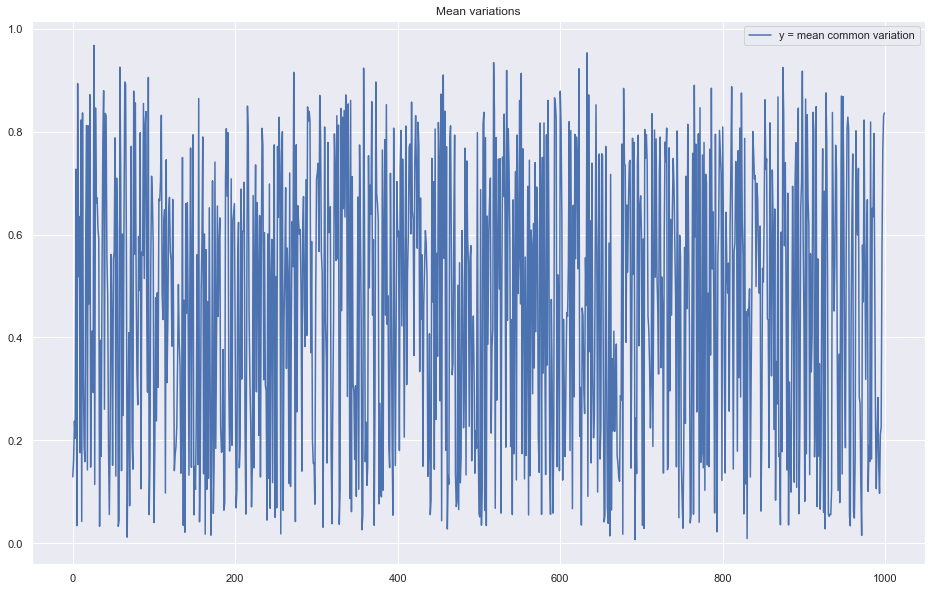

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


plt.figure(figsize=(16, 10))
plt.plot(np.arange(0, 1000, 1), Data_train.Mean.iloc[:1000], scaley = 100)
plt.title("Mean variations")
plt.legend(["y = mean common variation"])

plt.show()

<AxesSubplot:xlabel='Mean'>

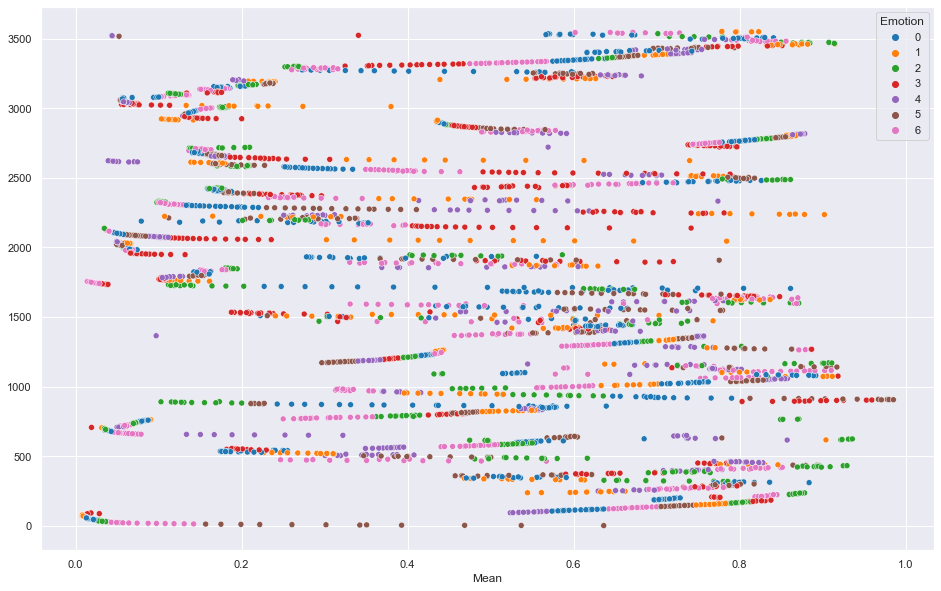

In [79]:
#Max	Min	Mean	Var	Mean Abs Diff	Mean Abs Second Diff	Emotion

sns.set(rc = {'figure.figsize':(16, 10)})
sns.set_theme(style="darkgrid")
sns.scatterplot(data = Data_train, x = "Mean", y = Data_train.index, hue = "Emotion", palette = "tab10", x_bins= 150)
#sns.lineplot(data = Data_train.iloc[:1500], x = Data_train.Mean.iloc[:1500], y = np.arange(0, 1500, 1), hue = "Emotion", palette = "tab10")

In [80]:
Data_train.isna().sum()

User                    0
Max                     0
Min                     0
Mean                    0
Var                     0
Mean Abs Diff           0
Mean Abs Second Diff    0
Emotion                 0
Gender                  0
Age                     0
dtype: int64

In [81]:
Data_train.Emotion.value_counts()

0    699
6    676
3    475
5    472
2    436
4    434
1    362
Name: Emotion, dtype: int64

####  Data is distributed normally. No NaN values. Sad and happy emotions have more samples than others -> might have to equalize value counts

# Classification 

In [82]:
from sklearn.model_selection import train_test_split

#Splitting and transofrming train data
y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion', 'User'], axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)
X_train.shape

#Transforming validation data
y_val = Data_val.Emotion
X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

In [83]:
from sklearn.metrics import accuracy_score

#OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)
print('One vs Rest classifier accuracy: ', accuracy_score(y_test, clf.predict(X_test)))

#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

print('KNeighborsClassifier accuracy: ', accuracy_score(y_test, clf.predict(X_test)))

One vs Rest classifier accuracy:  0.15463917525773196
KNeighborsClassifier accuracy:  0.5267104029990628


In [84]:
print('KNeighborsClassifier accuracy on validation data: ', accuracy_score(y_val, clf.predict(X_val)))

KNeighborsClassifier accuracy on validation data:  0.13126079447322972


##### Using Tensorflow models

### Modeling

In [85]:
import tensorflow as tf


def initModel(shape, outputUnits, outputActivation) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    
    inputs = tf.keras.Input(shape = (shape))
    expand = tf.expand_dims(inputs, axis = 2)

    gru = tf.keras.layers.GRU(256, return_sequences = True)(expand)
    flatten = tf.keras.layers.Flatten()(gru)

    outputs = tf.keras.layers.Dense(outputUnits, activation = outputActivation)(flatten)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    print(model.summary())
    return model

In [96]:
#Trying adam optimizer
model = initModel(X.shape[1], 7, 'softmax')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X,
    y,
    validation_split = 0.3,
    #validation_data = (X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

#Result of adam optimizer
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Validation Accuracy: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 8, 1)             0         
                                                                 
 gru (GRU)                   (None, 8, 256)            198912    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 213,255
Trainable params: 213,255
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
78/78 [==============================] 

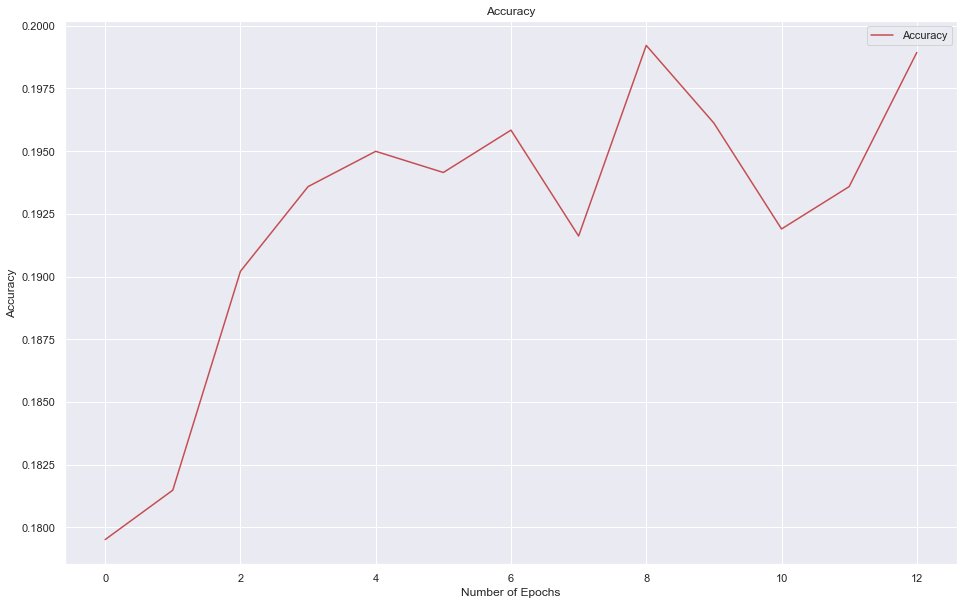

In [87]:
# Plot the accuracy curve for training
plt.plot(history.history['accuracy'], color='r', label="Accuracy")

plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [88]:
model.predict(X)

array([[0.20647939, 0.08643669, 0.11021604, ..., 0.09531212, 0.15467958,
        0.17774421],
       [0.20786437, 0.08514918, 0.11438382, ..., 0.09531529, 0.15431531,
        0.17537943],
       [0.20039476, 0.08980245, 0.11292478, ..., 0.09861495, 0.15939185,
        0.17023043],
       ...,
       [0.2122449 , 0.08267308, 0.11387281, ..., 0.0932148 , 0.15127507,
        0.17934544],
       [0.18330194, 0.11126268, 0.14200234, ..., 0.11382287, 0.14121316,
        0.16457507],
       [0.16575213, 0.12514521, 0.14168262, ..., 0.12362806, 0.15202737,
        0.14843671]], dtype=float32)

### Creating valence column
#### Emotion is valence (1) on surprise, neutral and happy; otherwise valence is 0 (disgust, angry, fear, sad)

In [98]:
#labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral']
def getValence(row) -> int:
    if row['Emotion'] == 0 or row['Emotion'] == 1 or row['Emotion'] == 6:
        return 1
    else:
        return 0
    
Data_train['Valence'] = Data_train.apply(lambda row: getValence(row), axis = 1)
Data_val['Valence'] = Data_val.apply(lambda row: getValence(row), axis = 1)

y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion', 'User'], axis = 1))

y_val = Data_val.Emotion
X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

In [99]:
model = initModel(X.shape[1], 7, 'softmax')

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X,
    y,
    validation_split = 0.2,
    #validation_data = (X_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

#Result of adam optimizer
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Validation Accuracy: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 9, 1)             0         
                                                                 
 gru (GRU)                   (None, 9, 256)            198912    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 7)                 16135     
                                                                 
Total params: 215,047
Trainable params: 215,047
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
89/89 [==============================]

Epoch 51/100
89/89 [==============================] - 2s 22ms/step - loss: 1.2059 - accuracy: 0.3651 - val_loss: 1.1945 - val_accuracy: 0.3615
Epoch 52/100
89/89 [==============================] - 2s 22ms/step - loss: 1.1985 - accuracy: 0.3774 - val_loss: 1.2083 - val_accuracy: 0.3615
Epoch 53/100
89/89 [==============================] - 2s 24ms/step - loss: 1.2067 - accuracy: 0.3679 - val_loss: 1.1916 - val_accuracy: 0.3741
Epoch 54/100
89/89 [==============================] - 2s 22ms/step - loss: 1.1940 - accuracy: 0.3788 - val_loss: 1.1929 - val_accuracy: 0.4079
Epoch 55/100
89/89 [==============================] - 2s 22ms/step - loss: 1.1996 - accuracy: 0.3757 - val_loss: 1.1899 - val_accuracy: 0.3826
Epoch 56/100
89/89 [==============================] - 2s 22ms/step - loss: 1.1946 - accuracy: 0.3834 - val_loss: 1.1980 - val_accuracy: 0.3896
Epoch 57/100
89/89 [==============================] - 2s 22ms/step - loss: 1.1905 - accuracy: 0.3743 - val_loss: 1.1903 - val_accuracy: 0.3812

### With valence given accuracy rose significantly (To 30.2%). Now will predict valence from initial data 

In [111]:
Data_train['Valence'] = Data_train.apply(lambda row: getValence(row), axis = 1)
Data_val['Valence'] = Data_val.apply(lambda row: getValence(row), axis = 1)

y_valence = np.asarray(Data_train.Valence).astype('float32')
y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Valence', 'Emotion', 'User'], axis = 1, inplace = False))

y_val_valence = np.asarray(Data_val.Valence).astype('float32')
y_val = Data_val.Emotion
X_val = pd.DataFrame(Data_val.drop(['Valence', 'Emotion', 'User'], axis = 1, inplace = False))

y_valence

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [115]:
from tensorflow.keras.layers import Dense
tf.keras.backend.clear_session()
valenceModel = tf.keras.models.Sequential()

valenceModel.add(Dense(8, input_dim = X.shape[1], activation = 'relu'))
valenceModel.add(tf.keras.layers.BatchNormalization())
valenceModel.add(Dense(4, activation = 'relu'))
valenceModel.add(tf.keras.layers.BatchNormalization())
valenceModel.add(Dense(1, activation = 'sigmoid'))

valenceModel.summary()


valenceModel.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = valenceModel.fit(
    X,
    y_valence,
    validation_data = (X_val, y_val_valence),
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

#Result of adam optimizer
model_acc = valenceModel.evaluate(X_val, y_val_valence, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 161
Trainable params: 137
Non-trainable pa

values = model.predict(X_val)
values = [int(value >= 0.5) for value in values]
print('accuracy: ', accuracy_score(y_val_valence, values))

In [105]:
y_valence = valenceModel.predict(X)
y_val_valence = valenceModel.predict(X_val)
y_valence

array([[9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05],
       [9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05],
       [9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05],
       ...,
       [9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05],
       [9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05],
       [9.9998629e-01, 9.9998623e-01, 9.9998623e-01, 1.5271280e-05]],
      dtype=float32)